In [2]:
# conda env pytorchaudio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import librosa

from mobilenetV3_mfcc import mobilenet_v3_mfcc


# MFCC 데이터셋 클래스 정의
class MFCCDataset(Dataset):
    def __init__(self, mfcc_data, labels, transform=None):
        self.mfcc_data = mfcc_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        mfcc = self.mfcc_data[idx]
        # mfcc = np.expand_dims(mfcc, axis=0)
        label = self.labels[idx]
        if self.transform:
            mfcc = self.transform(mfcc)
        return mfcc, label

# 데이터 증강을 위한 커스텀 변환
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

# wav 파일을 MFCC로 변환하는 함수
def wav_to_mfcc(file_path, n_mfcc=40, max_len=50): # 음원을 1.6(max_len=50)초로 자르고 mfcc 추출
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # MFCC의 길이를 max_len으로 맞추기
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# 데이터 로드 함수
def load_data(data_dir, n_mfcc=40, max_len=50): # 음원을 1.25(max_len=50)초로 자르고, 40개의 mfcc를 추출
    mfcc_data = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # 클래스 이름을 정렬하여 일관성 유지
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                mfcc = wav_to_mfcc(file_path, n_mfcc, max_len)
                mfcc_data.append(mfcc)
                labels.append(label)
    
    return np.array(mfcc_data), np.array(labels), class_names

In [3]:
# 훈련 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda:1'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # 검증
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 최고의 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'weights/test_mobilenetV3_mfcc_model.pth')

    print('Training completed.')

In [4]:
### 데이터 로드
# training data
train_data_dir = './warn_data'
X_train, y_train, class_names = load_data(train_data_dir)
num_classes = len(class_names)
num_mfcc = X_train.shape[1]
print(f"Loaded {len(X_train)} samples from {num_classes} classes.")

# validation data
val_data_dir = train_data_dir
X_val, y_val, class_names = load_data(val_data_dir)
num_classes = len(class_names)
num_mfcc = X_val.shape[1]
print(f"Loaded {len(X_val)} samples from {num_classes} classes.")
print(f"Class names: {class_names}")

# 데이터를 (num_samples, 1, num_mfcc, time_steps) 형태로 변경
# X = X.reshape(X.shape[0], 1, num_mfcc, X.shape[2])

# 데이터 변환 및 증강
use_augmentation = True
if use_augmentation:
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., 0.05)
    ])
else:
    train_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
val_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MFCCDataset(X_train, y_train, transform=train_transform)
val_dataset = MFCCDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    

Processing 충격깨짐소리: 100%|██████████| 39/39 [00:00<00:00, 57.68it/s]


Loaded 205 samples from 4 classes.


Processing 충격깨짐소리: 100%|██████████| 39/39 [00:00<00:00, 55.00it/s]

Loaded 205 samples from 4 classes.
Class names: ['경보음', '비명', '일반', '충격깨짐소리']


In [5]:
## 훈련 코드
# 모델, 손실 함수, 옵티마이저 초기화
model = mobilenet_v3_mfcc(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 모델 훈련
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

Epoch 1/20: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Epoch 1/20:
Train Loss: 1.0302, Train Acc: 0.6293
Val Loss: 1.2877, Val Acc: 0.6390


Epoch 2/20: 100%|██████████| 13/13 [00:00<00:00, 19.80it/s]


Epoch 2/20:
Train Loss: 0.6991, Train Acc: 0.7317
Val Loss: 1.3359, Val Acc: 0.6390


Epoch 3/20: 100%|██████████| 13/13 [00:00<00:00, 19.51it/s]


Epoch 3/20:
Train Loss: 0.5556, Train Acc: 0.8049
Val Loss: 1.5916, Val Acc: 0.0634


Epoch 4/20: 100%|██████████| 13/13 [00:00<00:00, 19.76it/s]


Epoch 4/20:
Train Loss: 0.3910, Train Acc: 0.8683
Val Loss: 1.5121, Val Acc: 0.6390


Epoch 5/20: 100%|██████████| 13/13 [00:00<00:00, 21.36it/s]


Epoch 5/20:
Train Loss: 0.3030, Train Acc: 0.8976
Val Loss: 1.6579, Val Acc: 0.1659


Epoch 6/20: 100%|██████████| 13/13 [00:00<00:00, 19.76it/s]


Epoch 6/20:
Train Loss: 0.1768, Train Acc: 0.9317
Val Loss: 0.3170, Val Acc: 0.8878


Epoch 7/20: 100%|██████████| 13/13 [00:00<00:00, 20.67it/s]


Epoch 7/20:
Train Loss: 0.1598, Train Acc: 0.9561
Val Loss: 0.0628, Val Acc: 0.9854


Epoch 8/20: 100%|██████████| 13/13 [00:00<00:00, 19.78it/s]


Epoch 8/20:
Train Loss: 0.1367, Train Acc: 0.9610
Val Loss: 0.0747, Val Acc: 0.9756


Epoch 9/20: 100%|██████████| 13/13 [00:00<00:00, 21.99it/s]


Epoch 9/20:
Train Loss: 0.1467, Train Acc: 0.9463
Val Loss: 0.0939, Val Acc: 0.9610


Epoch 10/20: 100%|██████████| 13/13 [00:00<00:00, 20.51it/s]


Epoch 10/20:
Train Loss: 0.1541, Train Acc: 0.9512
Val Loss: 0.0422, Val Acc: 0.9902


Epoch 11/20: 100%|██████████| 13/13 [00:00<00:00, 20.57it/s]


Epoch 11/20:
Train Loss: 0.1379, Train Acc: 0.9463
Val Loss: 0.0329, Val Acc: 0.9902


Epoch 12/20: 100%|██████████| 13/13 [00:00<00:00, 19.71it/s]


Epoch 12/20:
Train Loss: 0.1556, Train Acc: 0.9512
Val Loss: 0.0319, Val Acc: 0.9951


Epoch 13/20: 100%|██████████| 13/13 [00:00<00:00, 20.59it/s]


Epoch 13/20:
Train Loss: 0.1655, Train Acc: 0.9415
Val Loss: 0.0642, Val Acc: 0.9805


Epoch 14/20: 100%|██████████| 13/13 [00:00<00:00, 19.83it/s]


Epoch 14/20:
Train Loss: 0.1552, Train Acc: 0.9366
Val Loss: 0.0520, Val Acc: 0.9902


Epoch 15/20: 100%|██████████| 13/13 [00:00<00:00, 21.66it/s]


Epoch 15/20:
Train Loss: 0.2137, Train Acc: 0.9317
Val Loss: 0.0543, Val Acc: 0.9805


Epoch 16/20: 100%|██████████| 13/13 [00:00<00:00, 20.25it/s]


Epoch 16/20:
Train Loss: 0.0958, Train Acc: 0.9659
Val Loss: 0.0197, Val Acc: 0.9951


Epoch 17/20: 100%|██████████| 13/13 [00:00<00:00, 19.15it/s]


Epoch 17/20:
Train Loss: 0.0579, Train Acc: 0.9805
Val Loss: 0.0249, Val Acc: 0.9902


Epoch 18/20: 100%|██████████| 13/13 [00:00<00:00, 19.89it/s]


Epoch 18/20:
Train Loss: 0.1584, Train Acc: 0.9512
Val Loss: 0.0424, Val Acc: 0.9902


Epoch 19/20: 100%|██████████| 13/13 [00:00<00:00, 20.38it/s]


Epoch 19/20:
Train Loss: 0.1228, Train Acc: 0.9659
Val Loss: 0.0243, Val Acc: 0.9902


Epoch 20/20: 100%|██████████| 13/13 [00:00<00:00, 19.33it/s]


Epoch 20/20:
Train Loss: 0.1005, Train Acc: 0.9854
Val Loss: 0.0290, Val Acc: 0.9951
Training completed.


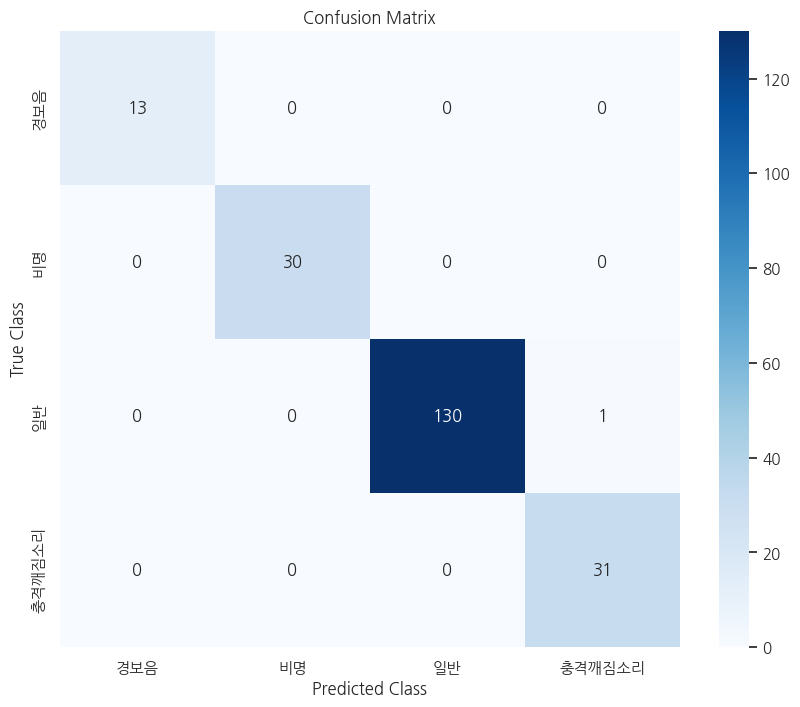

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn 한글 폰트 설정
sns.set_theme(font='NanumGothic')

# 모델 로드
model = mobilenet_v3_mfcc(num_classes=num_classes)
model.load_state_dict(torch.load('weights/test_mobilenetV3_mfcc_model.pth'))

model = model.to("cuda:1")
model.eval()

# 검증 데이터셋 예측
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [7]:
from sklearn.metrics import f1_score

# F1 스코어 계산
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9951
